In each case we compare the standard Isolation Forest with the Extended Isolation Forest using the eif package. The eif and tsfresh package can easily be installed using pip as follows:

In [1]:
!pip install tsfresh
!pip install eif

     |████████████████████████████████| 81kB 3.3MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=8cf97886f28e3539dfdad2d232655212a08d019fca933114b851e7e82e516c16
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket
     |████████████████████████████████| 1.6MB 4.6MB/s 
  Created wheel for eif: filename=eif-2.0.2-cp36-cp36m-linux_x86_64.whl size=250756 sha256=4cca2ce9b721de52c5baa709e24206f404f83346a8ae93dd08e62e3bc8d24134
  Stored in directory: /root/.cache/pip/wheels/24/ff/c3/6a610ba4a6c8e968483ba15a0e38feacd7c0a26c932b2f91bd
Successfully built eif


# **Import**

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import pandas as pd
import csv
from google.colab import drive
from scipy import stats
import datetime
dir=!ls
print(dir[0])
drive.mount("/content/gdrive")

 anomaly2.ipynb			      MotorElectrico01.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.chdir('/content/gdrive/My Drive/Cables Palas/model')
import utils as utils
from utils import *

#**Utility Functions**

In [0]:
def multiply_by_menosuno(arr):
    return np.multiply(arr,-1)
def mul_menosuno_y_div_diez(arr):
    return np.multiply(arr,-0.1)
def conv_digmode(arr):
    return arr & 2
def conv_dipper_trip(arr):
    return arr & 1

reading file with time intervals cycle 1 getting from notebook ""

In [5]:

pair=[]

csvfile="/content/gdrive/My Drive/Detect Ciclos/times_eddy_ciclo1.csv"
with open(csvfile, newline='') as output:
    csv_reader = csv.reader(output)
    line_count = 0
    times_temp=[]
    for row in csv_reader:
        
        if len(row[0].split(','))==2:
          
          times_temp.append(pd.to_datetime(row[0].split(',')[0][12:31], utc=True, format='%Y-%m-%d %H:%M:%S'))
          times_temp.append(pd.to_datetime(row[0].split(',')[1][12:31], utc=True, format='%Y-%m-%d %H:%M:%S'))
          pair.append(times_temp)
          times_temp=[]
        
          line_count += 1
    print(f'Processed {line_count} lines.')

Processed 10397 lines.


# function transforms data frame into tsfresh format

In [0]:

def tsfresh_timeSeries(_df,_pair_splits,global_column):
  new_temp=pd.DataFrame(columns=['id']+list(global_column))
  super_frame=[]
  bar = progressbar.ProgressBar(maxval=len(_pair_splits), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  j=0
  for _pair in _pair_splits:
    df=_df[_pair[0]:_pair[1]].reset_index()
    df.insert(0,"id",[j]*df.shape[0],True)
    df['DATE_TIME']=[i for i in range(0,df.shape[0])]
    super_frame.append(df)
    j=j+1
    bar.update(j)
    sleep(0.001)
  new_temp=pd.concat(super_frame,axis=0,ignore_index=True)
  bar.finish()
  return new_temp

# **Generate/LOAD Data from MIDAS**

In [0]:

url="/content/gdrive/My Drive/Detect Ciclos/PALA1_2018.csv.zip" 
df = pd.read_csv(url) 


Features selected by expert

In [0]:
df_expert=df[['DATE_TIME','MACHINE_IDENTIFIER','DIPPER_LOAD','CURRENT_TRUCK_LOAD','LAST_TRUCK_LOAD','SHIFT_TONS','LINE_VOLTAGE',
	'MOTION_CONTROL_KW','POWER_FACTOR','MACHINE_KW','HOIST_SPEED','HOIST_TORQUE','HOIST_IW','HOIST_KW','HOIST_SPEED_REF','HOIST_MOTOR_TEMP',
  'CROWD_EXTENSION','HOIST_ROPE_LENGTH','SWING_ANGLE','HOIST_DRUM_R_BEAR_TEMP','HOIST_DRUM_L_BEAR_TEMP','HOIST_UP_IN_PINION_BEAR_TEMP',
  'HOIST_LOW_IN_PINION_BEAT_TEMP','HOIST_MTR_R_BEAR_TEMP','HOIST_MTR_L_BEAR_TEMP','HOIST_GEARCASE_OIL_TEMP','CROWD_SPEED','CROWD_TORQUE',
  'CROWD_TORQUE','CROWD_IW','CROWD_KW','CROWD_SPEED_REF','CROWD_MOTOR_TEMP','BETA_ANGLE','CROWD_DRUM_R_BEAR_TEMP','CROWD_DRUM_L_BEAR_TEMP',
  'CROWD_IN_SHAFT_IN_BEAR_TEMP','CROWD_IN_SHAFT_OUT_BEAR_TEMP','CROWD_1_INTER_SHAFT_IN_BEAR_TEMP','CROWD_1_INTER_SHAFT_OUT_BEAR_TEMP',
  'CROWD_2_INTER_SHAFT_IN_BEAR_TEMP','CROWD_2_INTER_SHAFT_OUT_BEAR_TEMP','CROWD_MOTOR_R_BEAR_TEMP','CROWD_MOTOR_L_BEAR_TEMP','SWING_SPEED',
  'SWING_TORQUE','SWING_IW','SWING_KW','SWING_MS_REF','SWING_1_MOTOR_TEMP','SWING_2_MOTOR_TEMP','TOTAL_TILT','FORE_AFT_TILT',
  'SIDE_SIDE_TILT','CYCLE_SWING_ANGLE','OUTSIDE_AMBIENT_AIR_TEMPERATURE','HOUSE_AMBIENT_AIR_TEMPERATURE','SWING_GEARCASE_1_UP_FORE_BEARING_TEMP',
  'SWING_GEARCASE_1_LOW_AFT_BEARING_TEMP','SWING_MTR_1_UP_BEAR_TEMP','SWING_MTR_1_LOW_BEAR_TEMP','SWING_GEARCASE_2_UP_FORE_BEARING_TEMP',
  'SWING_GEARCASE_2_LOW_AFT_BEARING_TEMP','SWING_MTR_2_UP_BEAR_TEMP','SWING_MTR_2_LOW_BEAR_TEMP','STATUS_BYTE_1','STATUS_BYTE_2','STATUS_BYTE_3','STATUS_BYTE_4',
  'STATUS_BYTE_5','STATUS_BYTE_6','HC_STATES_BYTE_1','HC_STATES_BYTE_2','HC_STATES_BYTE_3','HC_STATES_BYTE_4','MACHINE_OPERATING_HOURS']]

In [0]:
global_column=df_expert.columns

transformation used to split time series by cycle

In [0]:
df_expert['HOIST_ROPE_LENGTH_INV'] = df_expert[['HOIST_ROPE_LENGTH']].apply(multiply_by_menosuno)
df_expert['HOIST_SPEED_INV'] = df_expert.loc[:,'HOIST_SPEED'].apply(mul_menosuno_y_div_diez)
df_expert['DIG_MODE'] = df_expert.loc[:,'STATUS_BYTE_3'].apply(conv_digmode) # nos indica que se encuentra en modo excavación
df_expert['DIPEER_TRIP'] = df_expert.loc[:,'STATUS_BYTE_3'].apply(conv_dipper_trip) # se activa con la orden de apretura de compuerta de balde
df_expert['HOIST_TORQUE_INV'] = df_expert[['HOIST_TORQUE']].apply(multiply_by_menosuno)
df_expert['HOIST_IW_INV'] = df_expert[['HOIST_IW']].apply(multiply_by_menosuno)

# BEST FEATURES USED BY THE EXPERT

In [0]:
features=['DATE_TIME','HOIST_SPEED_REF','CROWD_SPEED_REF','DIPEER_TRIP','HOIST_TORQUE_INV','HOIST_IW_INV','HOIST_KW','HOIST_SPEED_INV', 'HOIST_ROPE_LENGTH_INV', 'CROWD_EXTENSION','SWING_ANGLE']
df_expert_best = df_expert[['DATE_TIME','HOIST_SPEED_REF','CROWD_SPEED_REF','DIPEER_TRIP','HOIST_TORQUE_INV','HOIST_IW_INV','HOIST_KW','HOIST_SPEED_INV', 'HOIST_ROPE_LENGTH_INV', 'CROWD_EXTENSION','SWING_ANGLE']]

setting time series format

In [0]:
df_expert_best['DATE_TIME'] = df_expert_best['DATE_TIME'].apply(pd.Timestamp)
df_expert_best=df_expert_best.set_index('DATE_TIME')

transform dataframe in TSfresh format

In [13]:
df_tfresh=tsfresh_timeSeries(df_expert_best,pair,features)


[========================================================================] 100%


In [15]:
df_tfresh[0:-1]

,id,DATE_TIME,HOIST_SPEED_REF,CROWD_SPEED_REF,DIPEER_TRIP,HOIST_TORQUE_INV,HOIST_IW_INV,HOIST_KW,HOIST_SPEED_INV,HOIST_ROPE_LENGTH_INV,CROWD_EXTENSION,SWING_ANGLE
0,0,0,256,-27648,0,130,1113,-1015,-15.2,-47.07,23.97,68
1,0,1,-9215,-27648,0,119,1367,1674,79.8,-46.04,26.21,66
2,0,2,-21888,-27648,0,79,1289,2055,118.7,-42.95,28.82,65
3,0,3,-21888,-27648,0,100,1328,2055,95.8,-40.20,30.39,65
4,0,4,-21888,-27648,0,122,1386,2233,83.3,-37.80,31.24,66
...,...,...,...,...,...,...,...,...,...,...,...,...
183006,10396,8,-11136,-27648,0,125,1289,1852,68.0,-32.99,34.75,264
183007,10396,9,-5248,-27648,0,118,1171,50,59.0,-30.93,35.92,264
183008,10396,10,-18432,-27648,0,125,1289,1522,56.9,-29.55,36.92,264
183009,10396,11,-18816,16156,0,126,1308,1674,62.5,-27.83,37.38,265


# **Extract vector features based on tsfresh library**

In [16]:
from tsfresh import extract_features

# fc_parameters: contains the main functions to interact with tsfresh: extract features
fc_parameters = {
    "standard_deviation": None,
    "time_reversal_asymmetry_statistic": [{'lag':3}],
    "sum_of_reoccurring_values": None,
    "mean":None,
    "cid_ce": [{'normalize':False}]
}

X = extract_features(df_tfresh,fc_parameters,
                     column_id='id', column_sort='DATE_TIME')

Feature Extraction: 100%|██████████| 5/5 [00:49<00:00,  9.83s/it]


In [18]:
X[0:-1]

variable,CROWD_EXTENSION__cid_ce__normalize_False,CROWD_EXTENSION__mean,CROWD_EXTENSION__standard_deviation,CROWD_EXTENSION__sum_of_reoccurring_values,CROWD_EXTENSION__time_reversal_asymmetry_statistic__lag_3,CROWD_SPEED_REF__cid_ce__normalize_False,CROWD_SPEED_REF__mean,CROWD_SPEED_REF__standard_deviation,CROWD_SPEED_REF__sum_of_reoccurring_values,CROWD_SPEED_REF__time_reversal_asymmetry_statistic__lag_3,DIPEER_TRIP__cid_ce__normalize_False,DIPEER_TRIP__mean,DIPEER_TRIP__standard_deviation,DIPEER_TRIP__sum_of_reoccurring_values,DIPEER_TRIP__time_reversal_asymmetry_statistic__lag_3,HOIST_IW_INV__cid_ce__normalize_False,HOIST_IW_INV__mean,HOIST_IW_INV__standard_deviation,HOIST_IW_INV__sum_of_reoccurring_values,HOIST_IW_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_KW__cid_ce__normalize_False,HOIST_KW__mean,HOIST_KW__standard_deviation,HOIST_KW__sum_of_reoccurring_values,HOIST_KW__time_reversal_asymmetry_statistic__lag_3,HOIST_ROPE_LENGTH_INV__cid_ce__normalize_False,HOIST_ROPE_LENGTH_INV__mean,HOIST_ROPE_LENGTH_INV__standard_deviation,HOIST_ROPE_LENGTH_INV__sum_of_reoccurring_values,HOIST_ROPE_LENGTH_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_SPEED_INV__cid_ce__normalize_False,HOIST_SPEED_INV__mean,HOIST_SPEED_INV__standard_deviation,HOIST_SPEED_INV__sum_of_reoccurring_values,HOIST_SPEED_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_SPEED_REF__cid_ce__normalize_False,HOIST_SPEED_REF__mean,HOIST_SPEED_REF__standard_deviation,HOIST_SPEED_REF__sum_of_reoccurring_values,HOIST_SPEED_REF__time_reversal_asymmetry_statistic__lag_3,HOIST_TORQUE_INV__cid_ce__normalize_False,HOIST_TORQUE_INV__mean,HOIST_TORQUE_INV__standard_deviation,HOIST_TORQUE_INV__sum_of_reoccurring_values,HOIST_TORQUE_INV__time_reversal_asymmetry_statistic__lag_3,SWING_ANGLE__cid_ce__normalize_False,SWING_ANGLE__mean,SWING_ANGLE__standard_deviation,SWING_ANGLE__sum_of_reoccurring_values,SWING_ANGLE__time_reversal_asymmetry_statistic__lag_3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.745661,32.733571,4.187677,74.99,12652.594083,29544.497982,-20064.714286,14759.114673,-27648.0,6.966700e+12,0.0,0.000000,0.000000,0.0,0.0,348.353269,1315.071429,72.143175,5369.0,1.683179e+08,2786.785065,1801.142857,806.814712,5885.0,1.498953e+09,8.575343,-32.962143,9.013208,0.00,28884.345423,110.607504,79.778571,31.997861,0.0,169549.816250,17373.325819,-18349.642857,6541.997703,-21888.0,-9.638677e+11,67.638746,109.428571,22.433121,125.0,-174326.500000,5.477226,66.214286,1.933855,199.0,4.549000e+03
1,4.396328,32.086154,4.072706,0.00,13211.470907,55990.513062,-16931.153846,15053.826581,-27648.0,-2.046979e+11,0.0,0.000000,0.000000,0.0,0.0,90.614568,1366.692308,26.382933,4100.0,9.259091e+07,3318.850403,1812.923077,1108.503736,6596.0,1.645668e+09,8.675852,-33.409231,9.283548,0.00,33841.120591,155.989327,79.984615,45.563343,175.6,-102086.275143,13060.391418,-20145.230769,3218.080989,-21888.0,-2.413978e+11,50.566788,112.692308,13.864091,244.0,239211.857143,3.464102,49.000000,1.037749,97.0,1.317429e+03
2,4.790845,33.539286,3.980528,0.00,12348.618514,67979.487053,-17352.714286,19695.078538,0.0,-3.648110e+12,0.0,0.000000,0.000000,0.0,0.0,2131.286935,1214.642857,385.748735,4041.0,3.366085e+08,3438.022251,1775.857143,1073.852800,6571.0,5.303829e+08,8.395421,-33.011429,9.065236,0.00,29539.004064,104.130399,78.721429,34.451585,100.6,245104.815000,22263.538623,-18203.428571,8065.622124,-21888.0,-1.459420e+12,263.076035,94.500000,45.039269,125.0,74348.500000,4.898979,57.785714,1.933855,115.0,9.340875e+03
3,4.690714,29.770556,4.090276,27.52,8208.594773,69404.066163,-14192.666667,15728.894307,-27648.0,-4.380549e+12,0.0,0.000000,0.000000,0.0,0.0,1330.835076,1279.944444,226.695212,5467.0,3.482171e+08,2382.636985,1633.555556,1087.555067,8474.0,2.286077e+09,9.003605,-33.483889,10.809982,0.00,28974.329208,177.699128,65.083333,54.019536,90.2,-51255.883917,20302.430199,-20472.888889,3515.658827,-21888.0,-6.565606e+10,180.285884,111.111111,29.866162,251.0,174944.833333,13.784049,13

# drop all columns with less than two different values

In [19]:
dropmissedvalues(X)

[========================================================================] 100%


Normalization step

In [0]:
X=X.apply(lambda x:(x-x.min()) / (x.max()-x.min()))

# **Trees and training**

Now that we are working with high dimensional data, there are two extension levels to the standard isolation Forest. The extension level 2 is of course the fully extended case. 

In [0]:
sample = 256
F0 = iso.iForest(X.values,ntrees=500, sample_size=sample, ExtensionLevel=0) # Extension level 0 is the same as the standard Isolation Forest. 
F1 = iso.iForest(X.values,ntrees=500, sample_size=sample, ExtensionLevel=1)
F2 = iso.iForest(X.values,ntrees=500, sample_size=sample, ExtensionLevel=2)

# **Scores and distributions**

In [0]:
S0 = F0.compute_paths(X_in=X.values)
S1 = F1.compute_paths(X_in=X.values)
S2 = F2.compute_paths(X_in=X.values)

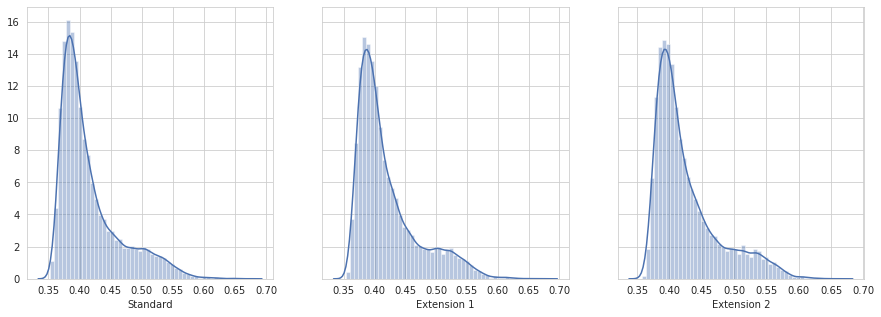

In [23]:
f, ax1 = plt.subplots(1,3,figsize=(15,5),sharey=True)

sb.distplot(S0, kde=True, color="b", ax=ax1[0], axlabel='Standard')
sb.distplot(S1, kde=True, color="b", ax=ax1[1], axlabel='Extension 1')
sb.distplot(S2, kde=True, color="b", ax=ax1[2], axlabel='Extension 2')

plt.show()

In [24]:
# Reduce dimensionality using TSNE
from sklearn.manifold import TSNE 
import time

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10397 samples in 0.075s...
[t-SNE] Computed neighbors for 10397 samples in 11.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10397
[t-SNE] Computed conditional probabilities for sample 2000 / 10397
[t-SNE] Computed conditional probabilities for sample 3000 / 10397
[t-SNE] Computed conditional probabilities for sample 4000 / 10397
[t-SNE] Computed conditional probabilities for sample 5000 / 10397
[t-SNE] Computed conditional probabilities for sample 6000 / 10397
[t-SNE] Computed conditional probabilities for sample 7000 / 10397
[t-SNE] Computed conditional probabilities for sample 8000 / 10397
[t-SNE] Computed conditional probabilities for sample 9000 / 10397
[t-SNE] Computed conditional probabilities for sample 10000 / 10397
[t-SNE] Computed conditional probabilities for sample 10397 / 10397
[t-SNE] Mean sigma: 0.176082
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.513535
[t-SNE] K

In [25]:
len(X_tsne)

10397

Here we plot the points and highlight a 7000 points with highest and 700 points with lowest anomaly scores. The two plots provide a comparison between the two algorithms.

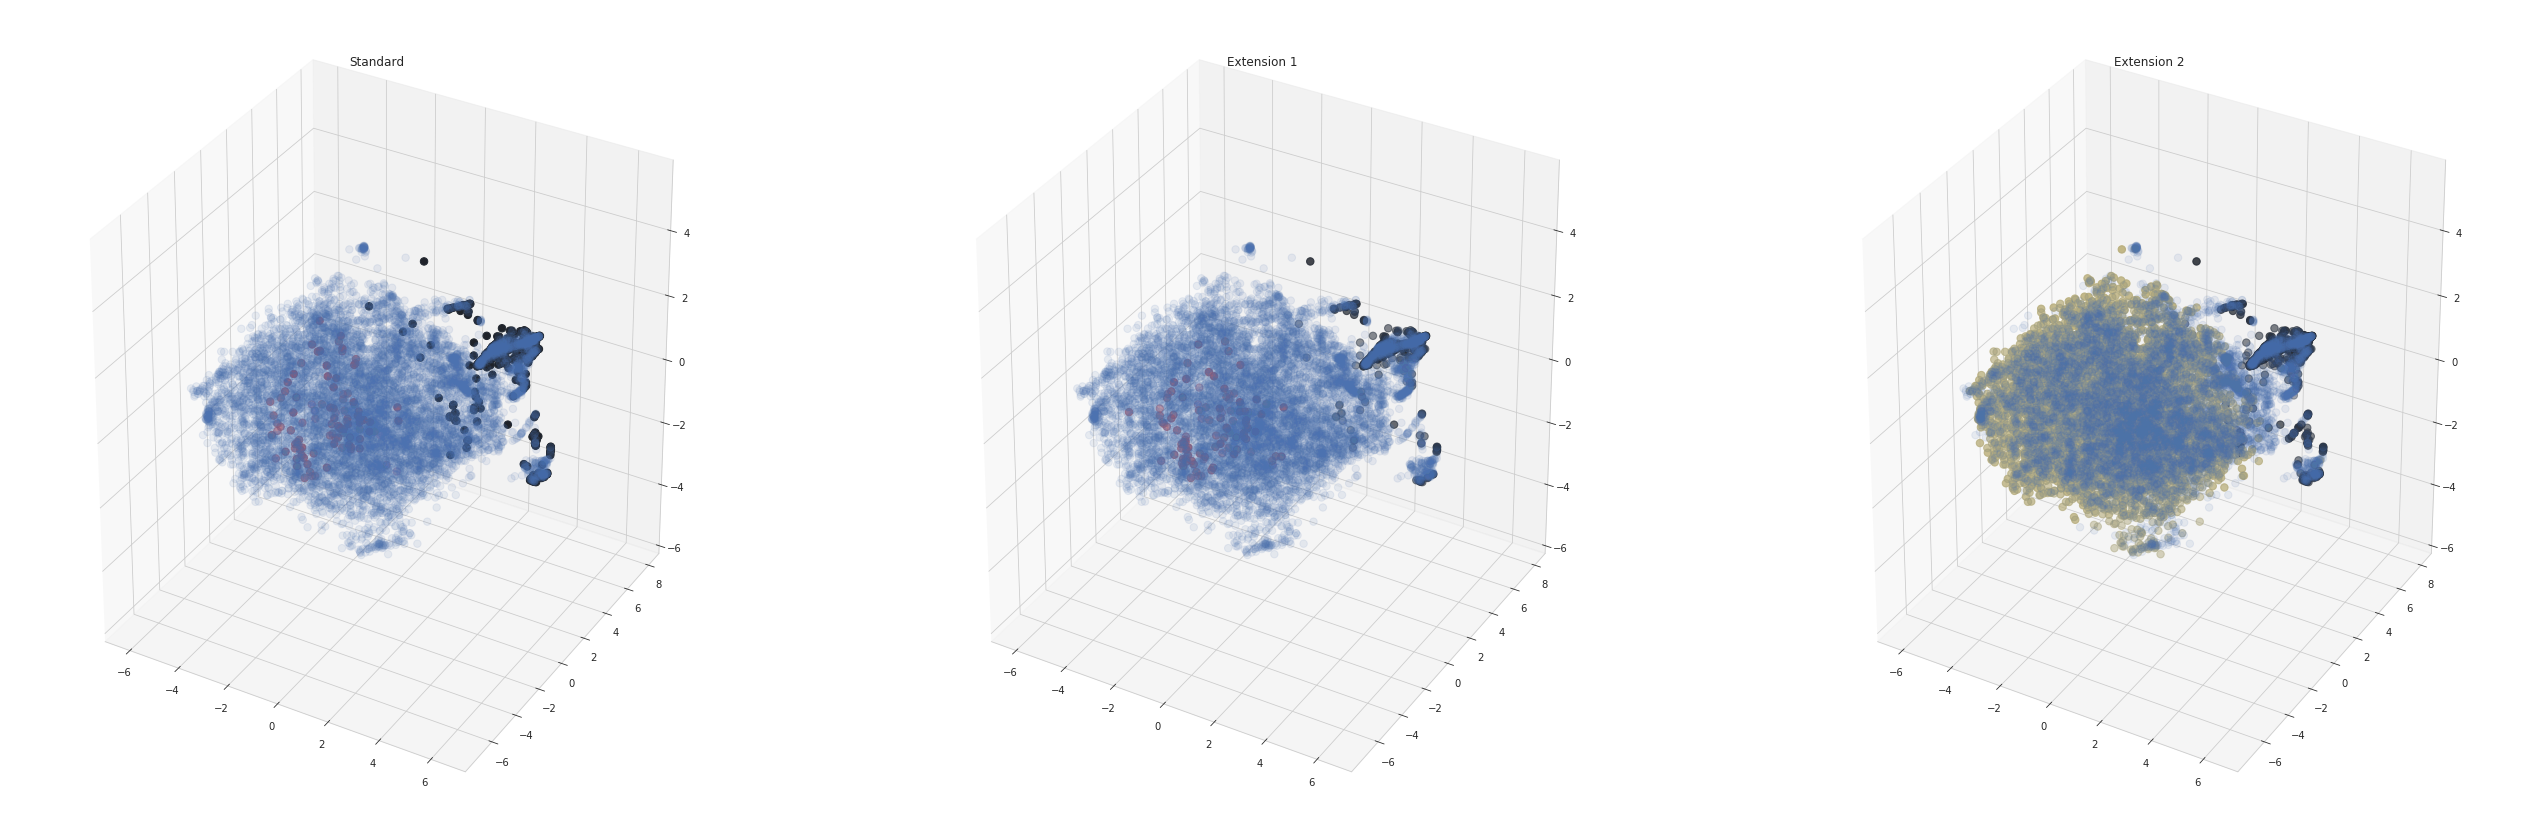

In [26]:
#Returns the indices that would sort an array.
#>>> x = np.array([3, 1, 2])
#>>> np.argsort(x)
#array([1, 2, 0])
ss0=np.argsort(S0)
ss1=np.argsort(S1)
ss2=np.argsort(S2)

x=X_tsne[:,0]
y=X_tsne[:,1]
z=X_tsne[:,2]
f = plt.figure(figsize=(45,15))
ax0 = f.add_subplot(131, projection='3d')
ax0.scatter(x,y,z,s=55,c='b',alpha=0.1)
ax0.scatter(x[ss0[-500:]],y[ss0[-500:]],z[ss0[-500:]],s=55,c='k',alpha=1)
ax0.scatter(x[ss0[:100]] ,y[ss0[:100]] ,z[ss0[:100]] ,s=55,c='r')
plt.title('Standard')

ax1 = f.add_subplot(132, projection='3d')
ax1.scatter(x,y,z,s=55,c='b',alpha=0.1)
ax1.scatter(x[ss1[-300:]],y[ss1[-300:]],z[ss1[-300:]],s=55,c='k')
ax1.scatter(x[ss1[:100]] ,y[ss1[:100]] ,z[ss1[:100]] ,s=55,c='r')
plt.title('Extension 1')

ax2 = f.add_subplot(133, projection='3d')
ax2.scatter(x,y,z,s=55,c='b',alpha=0.1)
ax2.scatter(x[ss2[-700:]],y[ss2[-700:]],z[ss2[-700:]],s=55,c='k')
ax2.scatter(x[ss2[:7000]] ,y[ss2[:7000]] ,z[ss2[:7000]] ,s=55,c='y')
plt.title('Extension 2')

plt.show()

select 9000 points with lowest anomaly scores beetween the three models inn order train autoencoders with only ***normal*** points

In [27]:
normal_points=[ elem for elem in ss0[:9000] if elem in ss1[:9000] if elem in ss2[:9000]]
#result = {element for element in a if element in b}
print(normal_points)

[4679, 2345, 4520, 445, 9125, 2714, 2015, 2375, 2815, 4662, 4139, 4106, 2443, 2429, 4220, 2665, 5671, 2938, 4940, 2377, 2660, 2442, 9420, 4104, 3021, 339, 223, 2418, 2831, 529, 4741, 9160, 522, 4786, 2467, 4680, 6899, 3036, 4319, 4778, 856, 4170, 6997, 3174, 2817, 6234, 313, 64, 1648, 553, 3048, 4728, 5699, 4367, 4608, 2346, 121, 2939, 159, 3223, 6999, 7156, 6279, 55, 2494, 4678, 902, 2739, 4623, 879, 9724, 6319, 4585, 6736, 376, 8765, 4269, 2519, 4584, 637, 4426, 7176, 286, 4566, 7414, 77, 4137, 169, 2791, 2591, 4715, 6709, 2373, 4840, 9126, 7116, 3145, 893, 7007, 4790, 2657, 7111, 248, 4638, 3161, 4729, 5564, 7155, 2229, 2880, 2535, 60, 4273, 264, 2493, 4755, 9437, 5066, 4537, 9665, 6298, 4837, 5797, 9102, 4832, 2907, 2785, 4410, 2751, 4504, 4789, 9746, 4309, 4689, 12, 4548, 8582, 2281, 175, 4831, 2646, 9130, 3005, 1143, 4289, 2501, 525, 2569, 4165, 4804, 2962, 2865, 4121, 6211, 7003, 57, 189, 4228, 7000, 112, 2673, 4339, 5978, 423, 210, 6233, 4056, 302, 2952, 380, 7223, 9752, 2278, 

In [0]:
X_normal_point=X.loc[normal_points]

save dataframe with normal points

In [29]:
X_normal_point.to_csv('/content/gdrive/My Drive/Cables Palas/model/normalPoints_PALA1_2018.csv')
X_normal_point[1:-1]

variable,CROWD_EXTENSION__cid_ce__normalize_False,CROWD_EXTENSION__mean,CROWD_EXTENSION__standard_deviation,CROWD_EXTENSION__sum_of_reoccurring_values,CROWD_EXTENSION__time_reversal_asymmetry_statistic__lag_3,CROWD_SPEED_REF__cid_ce__normalize_False,CROWD_SPEED_REF__mean,CROWD_SPEED_REF__standard_deviation,CROWD_SPEED_REF__sum_of_reoccurring_values,CROWD_SPEED_REF__time_reversal_asymmetry_statistic__lag_3,DIPEER_TRIP__cid_ce__normalize_False,DIPEER_TRIP__mean,DIPEER_TRIP__standard_deviation,DIPEER_TRIP__sum_of_reoccurring_values,HOIST_IW_INV__cid_ce__normalize_False,HOIST_IW_INV__mean,HOIST_IW_INV__standard_deviation,HOIST_IW_INV__sum_of_reoccurring_values,HOIST_IW_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_KW__cid_ce__normalize_False,HOIST_KW__mean,HOIST_KW__standard_deviation,HOIST_KW__sum_of_reoccurring_values,HOIST_KW__time_reversal_asymmetry_statistic__lag_3,HOIST_ROPE_LENGTH_INV__cid_ce__normalize_False,HOIST_ROPE_LENGTH_INV__mean,HOIST_ROPE_LENGTH_INV__standard_deviation,HOIST_ROPE_LENGTH_INV__sum_of_reoccurring_values,HOIST_ROPE_LENGTH_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_SPEED_INV__cid_ce__normalize_False,HOIST_SPEED_INV__mean,HOIST_SPEED_INV__standard_deviation,HOIST_SPEED_INV__sum_of_reoccurring_values,HOIST_SPEED_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_SPEED_REF__cid_ce__normalize_False,HOIST_SPEED_REF__mean,HOIST_SPEED_REF__standard_deviation,HOIST_SPEED_REF__sum_of_reoccurring_values,HOIST_SPEED_REF__time_reversal_asymmetry_statistic__lag_3,HOIST_TORQUE_INV__cid_ce__normalize_False,HOIST_TORQUE_INV__mean,HOIST_TORQUE_INV__standard_deviation,HOIST_TORQUE_INV__sum_of_reoccurring_values,HOIST_TORQUE_INV__time_reversal_asymmetry_statistic__lag_3,SWING_ANGLE__cid_ce__normalize_False,SWING_ANGLE__mean,SWING_ANGLE__standard_deviation,SWING_ANGLE__sum_of_reoccurring_values,SWING_ANGLE__time_reversal_asymmetry_statistic__lag_3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2345,0.500359,0.718605,0.550312,0.0,0.518508,0.237774,0.276739,0.605599,0.562648,0.475479,0.000000,0.000000,0.000000,0.0,0.032666,0.973597,0.046159,0.217813,0.514269,0.377178,0.928854,0.502703,0.421862,0.540359,0.302805,0.466665,0.651752,1.000000,0.340372,0.563424,0.569851,0.410904,0.282345,0.129264,0.310885,0.091672,0.222109,0.688758,0.541861,0.171041,0.885162,0.137300,0.106968,0.690176,0.013388,0.478711,0.011167,0.510400,0.832488
4520,0.536260,0.736408,0.566439,0.0,0.548404,0.283265,0.325426,0.644446,0.562648,0.540921,0.000000,0.000000,0.000000,0.0,0.038165,0.973810,0.038796,0.221597,0.498725,0.378747,0.913663,0.555713,0.564690,0.533075,0.308877,0.478635,0.591496,1.000000,0.342369,0.534138,0.579730,0.480945,0.100606,0.141493,0.212050,0.066230,0.185202,0.688758,0.521432,0.114121,0.799014,0.160941,0.090395,0.667996,0.022158,0.498160,0.021979,0.517852,0.832483
445,0.483384,0.709259,0.557123,0.0,0.478143,0.294355,0.211187,0.617677,0.562648,0.569165,0.000000,0.000000,0.000000,0.0,0.127533,0.929292,0.107546,0.277481,0.464450,0.500081,0.790872,0.499477,0.566413,0.459409,0.309562,0.542374,0.620959,1.000000,0.239077,0.509798,0.537664,0.354383,0.219169,0.134370,0.249561,0.244000,0.262300,0.688758,0.448277,0.140175,0.851624,0.177156,0.106215,0.642358,0.019740,0.614827,0.017840,0.596399,0.832266
9125,0.496067,0.678315,0.630768,0.0,0.547968,0.241806,0.210242,0.645233,0.562648,0.576925,0.000000,0.000000,0.000000,0.0,0.041975,0.959484,0.040957,0.217813,0.478982,0.369211,0.902658,0.509570,0.546207,0.474267,0.307376,0.580856,0.632406,1.000000,0.273488,0.547364,0.557353,0.426591,0.100606,0.124290,0.301967,0.099024,0.299375,0.688758,0.518550,0.164407,0.874100,0.161047,0.108851,0.664458,0.023020,0.538770,0.022392,0.550450,0.832471
2714,0.451285,0.800014,0.535931,0.0,0.543379,0.282673,0.144589,0.590477,0.562648,0.507061,0.000000,0.000000,0.000000,0.0,0.072189,0.944255,0.068929,0.151499,0.473231,0.399674,0.863599,0.536967,0.415104,0.481507,0.306907,0.530763,0.625666,1.000000,0.286982,0.518602,0.569411,0.383853,0.100606,0.140935,0.37

In [0]:

# saving training dataframe( normal points)
csvfile = "trainPALA1_2018.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in normal_points:
        writer.writerow([val])

In [31]:
anomaly_points=[ elem for elem in ss0[-1000:] if elem in ss1[-1000:] if elem in ss2[-1000:]]
len(anomaly_points)

860

In [0]:
X_anormal_point=X.loc[anomaly_points]

In [0]:
#saving anomaly cycles based on isolation forest models

anomaly_pairs=[pair[i] for i in anomaly_points]
csvfile = "cycle_anomaly_pointsPALA1_2018.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in anomaly_pairs:
        writer.writerow([val])

[Timestamp('2018-09-09 11:50:48+0000', tz='UTC'),
 Timestamp('2018-09-09 11:50:54+0000', tz='UTC')]

In [50]:
X_anormal_point[0:-1]

variable,CROWD_EXTENSION__cid_ce__normalize_False,CROWD_EXTENSION__mean,CROWD_EXTENSION__standard_deviation,CROWD_EXTENSION__sum_of_reoccurring_values,CROWD_EXTENSION__time_reversal_asymmetry_statistic__lag_3,CROWD_SPEED_REF__cid_ce__normalize_False,CROWD_SPEED_REF__mean,CROWD_SPEED_REF__standard_deviation,CROWD_SPEED_REF__sum_of_reoccurring_values,CROWD_SPEED_REF__time_reversal_asymmetry_statistic__lag_3,DIPEER_TRIP__cid_ce__normalize_False,DIPEER_TRIP__mean,DIPEER_TRIP__standard_deviation,DIPEER_TRIP__sum_of_reoccurring_values,HOIST_IW_INV__cid_ce__normalize_False,HOIST_IW_INV__mean,HOIST_IW_INV__standard_deviation,HOIST_IW_INV__sum_of_reoccurring_values,HOIST_IW_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_KW__cid_ce__normalize_False,HOIST_KW__mean,HOIST_KW__standard_deviation,HOIST_KW__sum_of_reoccurring_values,HOIST_KW__time_reversal_asymmetry_statistic__lag_3,HOIST_ROPE_LENGTH_INV__cid_ce__normalize_False,HOIST_ROPE_LENGTH_INV__mean,HOIST_ROPE_LENGTH_INV__standard_deviation,HOIST_ROPE_LENGTH_INV__sum_of_reoccurring_values,HOIST_ROPE_LENGTH_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_SPEED_INV__cid_ce__normalize_False,HOIST_SPEED_INV__mean,HOIST_SPEED_INV__standard_deviation,HOIST_SPEED_INV__sum_of_reoccurring_values,HOIST_SPEED_INV__time_reversal_asymmetry_statistic__lag_3,HOIST_SPEED_REF__cid_ce__normalize_False,HOIST_SPEED_REF__mean,HOIST_SPEED_REF__standard_deviation,HOIST_SPEED_REF__sum_of_reoccurring_values,HOIST_SPEED_REF__time_reversal_asymmetry_statistic__lag_3,HOIST_TORQUE_INV__cid_ce__normalize_False,HOIST_TORQUE_INV__mean,HOIST_TORQUE_INV__standard_deviation,HOIST_TORQUE_INV__sum_of_reoccurring_values,HOIST_TORQUE_INV__time_reversal_asymmetry_statistic__lag_3,SWING_ANGLE__cid_ce__normalize_False,SWING_ANGLE__mean,SWING_ANGLE__standard_deviation,SWING_ANGLE__sum_of_reoccurring_values,SWING_ANGLE__time_reversal_asymmetry_statistic__lag_3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2190,0.293184,0.563876,0.264637,0.000000,0.265622,0.081129,0.344413,0.333183,0.728876,0.500000,0.000000,0.000000,0.000000,0.0,0.207454,0.394942,0.285736,0.022703,0.466175,0.203675,0.546504,0.335145,0.127724,0.425427,0.106387,0.403440,0.129521,0.952183,0.000030,0.235210,0.399657,0.360254,0.100606,0.134593,0.128555,0.626929,0.289264,0.837844,0.501923,0.190878,0.417910,0.189987,0.013936,0.652087,0.002792,0.700928,0.003490,0.604781,0.832488
9288,0.416662,0.521081,0.428800,0.000000,0.526393,0.210828,0.409319,0.486310,0.728876,0.408687,0.000000,0.000000,0.000000,0.0,0.632913,0.361962,0.631491,0.022703,0.524688,0.555123,0.526589,0.514527,0.127724,0.445045,0.255867,0.163910,0.406840,1.000000,0.515976,0.365259,0.583719,0.440097,0.100606,0.240453,0.191080,0.470350,0.302384,0.837844,0.427787,0.500192,0.439859,0.492024,0.013936,0.439381,0.017656,0.499186,0.024127,0.519714,0.832535
9390,0.148162,0.276601,0.138460,0.000000,0.265622,0.058550,0.473631,0.204349,0.728876,0.500000,0.000000,0.000000,0.000000,0.0,0.063170,0.907249,0.081079,0.082371,0.466175,0.498413,0.590095,0.889511,0.262206,0.425427,0.263538,0.148854,0.304561,1.000000,0.000030,0.620429,0.611708,0.961758,0.100606,0.134593,0.101379,0.048532,0.112014,0.688758,0.501923,0.291048,0.465320,0.390470,0.013936,0.652087,0.025737,0.590918,0.045145,0.511332,0.832488
8830,0.634731,0.783781,0.780013,0.000000,0.806474,0.332594,0.234838,0.682459,0.562648,0.531448,0.577350,0.272727,0.899954,1.0,0.085061,0.930119,0.084197,0.154361,0.535266,0.456018,0.853624,0.661124,0.544551,0.505520,0.360736,0.464649,0.659213,1.000000,0.462420,0.545976,0.694641,0.566120,0.100606,0.197889,0.032278,0.006700,0.023645,0.688758,0.485993,0.162698,0.666453,0.156614,0.013936,0.589733,0.023189,0.494185,0.022522,0.517852,0.832493
5352,0.613465,0.736002,0.739674,0.000000,0.931249,0.143302,0.227848,0.455673,0.562648,0.517342,0.000000,0.000000,0.000000,0.0,0.032787,0.908831,0.043520,0.082371,0.413673,0.375316,0.802631,0.610839,0.255449,0.591111,0.434032,0.395270,0.694272,1.000000,0.719519,0.567293,0.854952,0.818

In [0]:
X_anormal_point.to_csv('AnormalPoints_PALA1_2018.csv')

In [0]:


csvfile = "testPALA1_2018.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in anomaly_points:
        writer.writerow([val])